# Adding external variables to models

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from itertools import product
from typing import Union

## Examining the SARIMAX model

**The SARIMAX model simply adds a linear combination of exogenous variables to the
SARIMA model. This allows us to model the impact of external variables on the future
value of a time series.**

## Forecasting the real GDP using the SARIMAX model

### Exploring the exogenous variables of the US macroeconomics dataset

In [2]:
import statsmodels.api as sm

macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


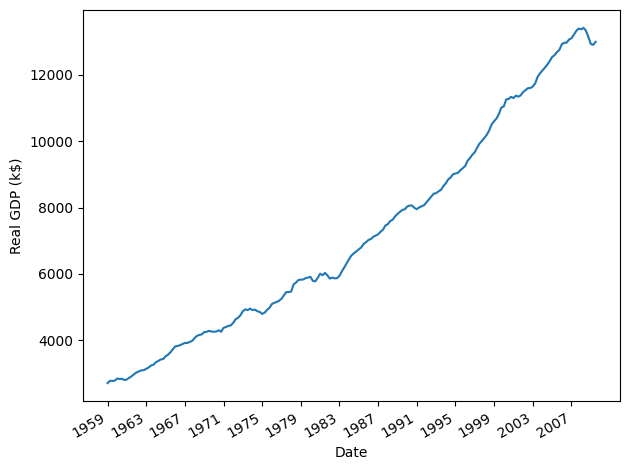

In [3]:
fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

- realgdp - Real gross domestic product (the target variable or endogenous variable)
- realcons - Real personal consumption expenditure
- realinv - Real gross private domestic investment
- realgovt - Real federal consumption expenditure and investment
- realdpi - Real private disposable income
- cpi - Consumer price index for the end of the quarter
- m1 - M1 nominal money stock
- tbilrate - Quarterly monthly average of the monthly 3-month treasury bill
- unemp - Unemployment rate
- pop - Total population at the end of the quarter
- infl - Inflation rate
- realint - Real interest rate

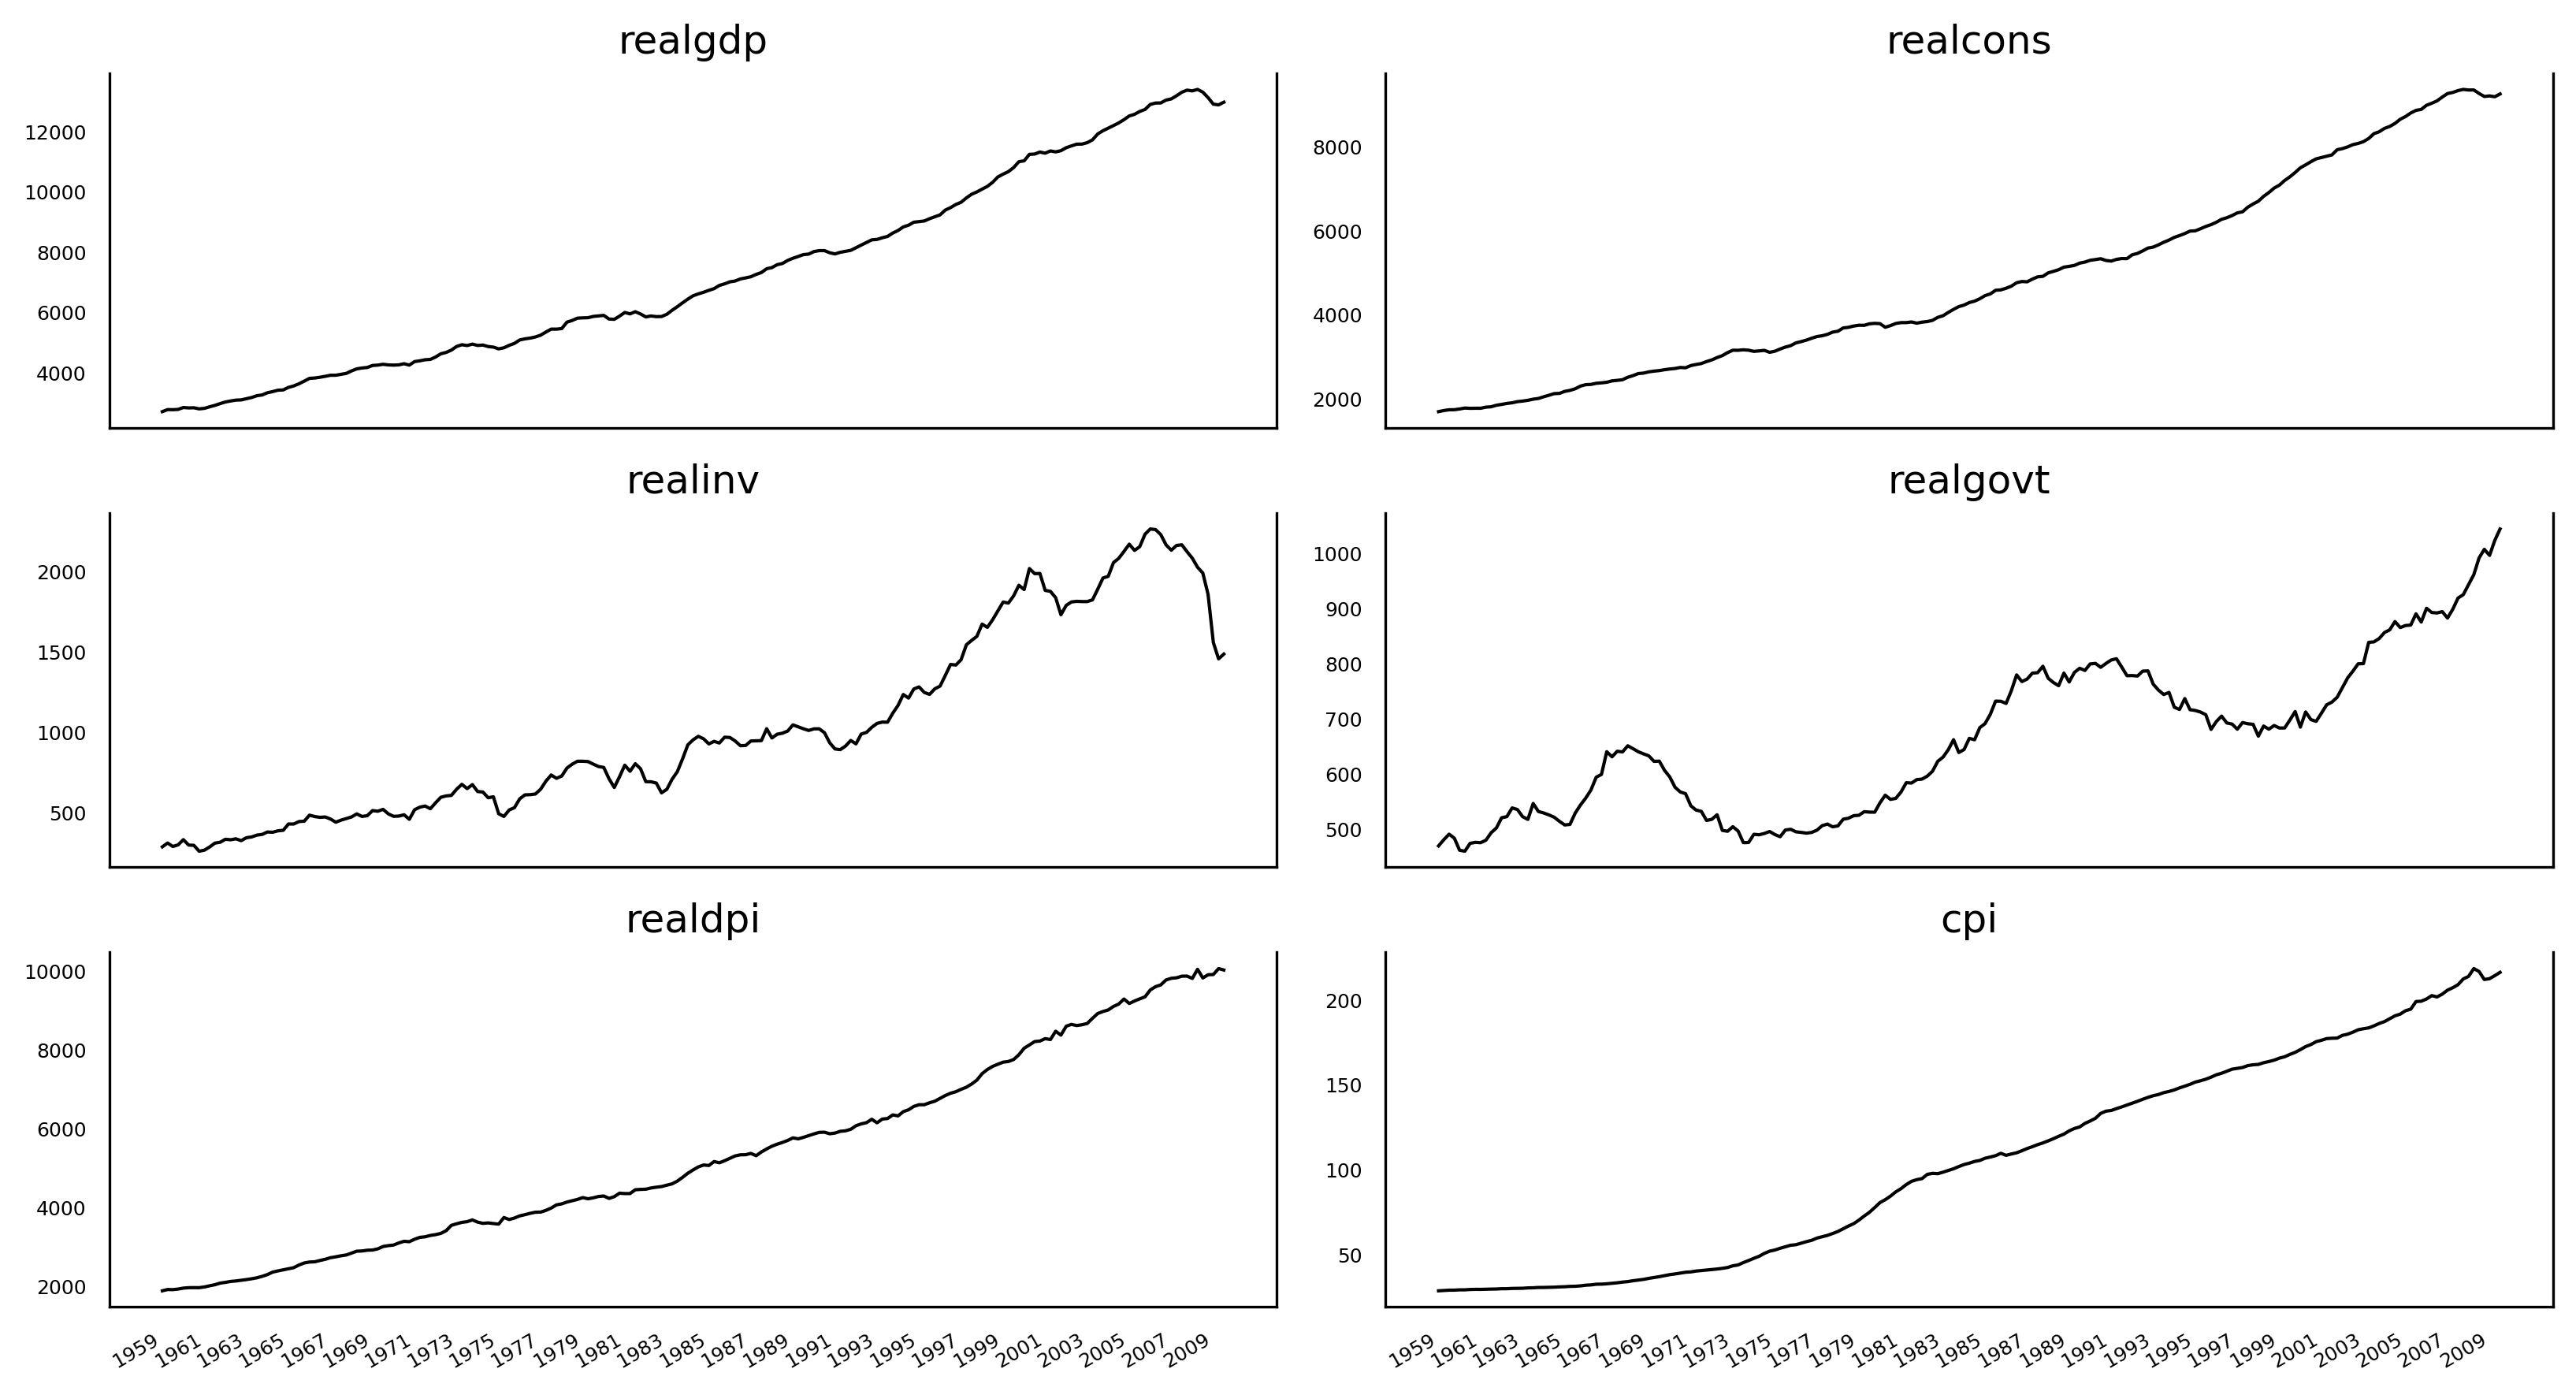

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

### Caveat for using SARIMAX

**If your exogenous variable is easy to predict, meaning that it
follows a known function that can be accurately predicted, there is no harm in forecasting
the exogenous variable and using these forecasts to predict the target.**

### Forecasting

In [5]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

In [6]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print("Critical values:")
for key, value in ad_fuller_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647182
Critical values:
   1%: -3.4652439354133255
   5%: -2.8768752281673717
   10%: -2.574944653739612
p-value: 0.9982455372335032


In [7]:
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print("Critical values:")
for key, value in ad_fuller_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658105
Critical values:
   1%: -3.463476079125
   5%: -2.876102355
   10%: -2.574532225
p-value: 3.327882187668224e-08


In [8]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [12]:
import warnings
warnings.filterwarnings('ignore')

target_train = target[:200]
exog_train = exog[:200]



In [ ]:
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

In [13]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.425
Date:                Tue, 11 Jun 2024   AIC                           1742.850
Time:                        17:59:20   BIC                           1782.370
Sample:                             0   HQIC                          1758.845
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9656      0.045     21.634      0.000       0.878       1.053
realinv        1.0137      0.033     30.874      0.000       0.949       1.078
realgovt       0.7275      0.127      5.733      0.0

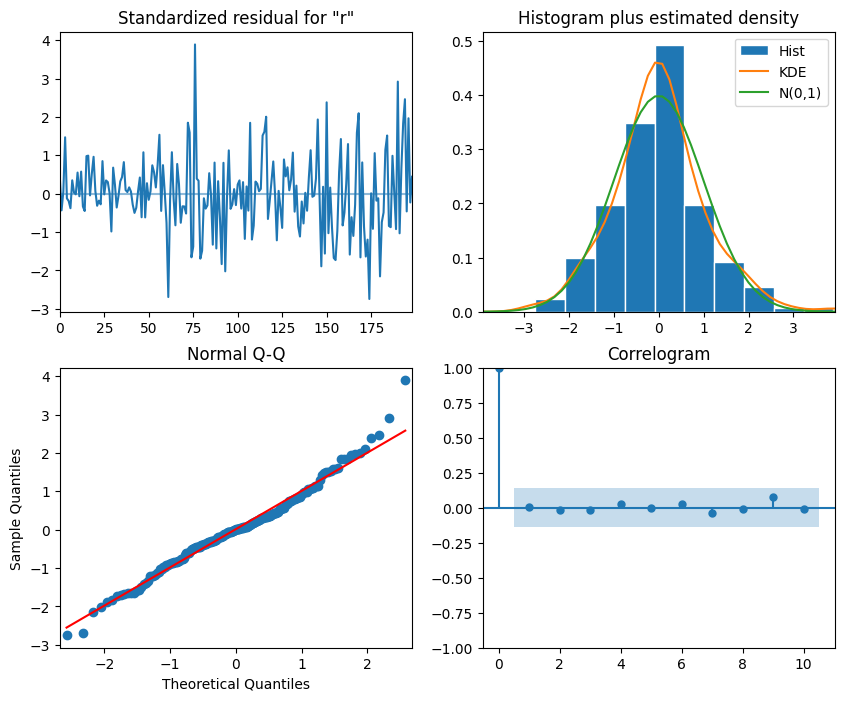

In [14]:
best_model_fit.plot_diagnostics(figsize=(10,8));

In [15]:
residuals = best_model_fit.resid

res = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(list(res["lb_pvalue"]))

[0.7804202030063704, 0.9004244537728191, 0.9750300780307514, 0.8836598085344065, 0.9478652285283727, 0.9775453707816031, 0.9859408549181816, 0.9942605512951513, 0.9946350088627011, 0.9978082262343113]


In [16]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [17]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.062993
197,13415.266,13366.865,13373.511812
198,13324.600,13415.266,13378.810338
199,13141.920,13324.600,13327.778801
200,12925.410,13141.920,13133.905996
201,12901.504,12925.410,12886.534978
202,12990.341,12901.504,12873.796912


In [18]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.7041676322585917


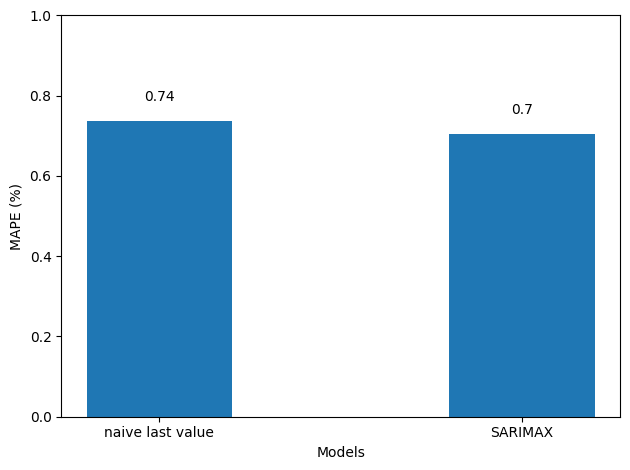

In [20]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

# Summary

Models are good when we have **small dataset (less than 10'000 points)**. Otherwise they take a long time. If we have larger datasets we usually use deep learning.

If data has more than 1 seasonality effect we again, use deep learing.